In [1]:
import gpytorch
import torch
from matplotlib import pyplot as plt
import numpy as np

In [2]:
nin = 50
train_x = torch.linspace(-10,10, nin)
train_y = torch.sin(train_x) + np.sqrt(0.08)*torch.randn(nin)
# torch is the pytorch library, which wraps numpy functions. The data variable is a tensor
# type rather than an array, which makes it easy to run them on GPUs.

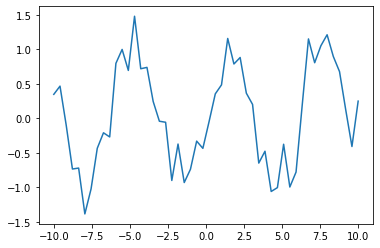

In [3]:
plt.plot(train_x, train_y)

In [4]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP): # setup the class which inherits the ExactGP model
    # initialize the class with X_input, Y_input and a likelihood
    def __init__(self, train_x, train_y, likelihood):
        
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # This calls the __init__ of the inherited class (gpytorch.models.ExactGP),
        # and passes the training data and a likelihood to it.
        # Also ExactGPModel objects have access to 'ExactGP' functions, since it has inherited it.
        
        # Chose a constant mean.
        self.mean_module = gpytorch.means.ConstantMean()
        # ScaleKernel gives the covariance function a scaling factor (K_scale = theta*K_orig)
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

        # forward takes some x input of size nXd (n-num samples, d-input dim),
        # and returns the multivariate gaussian with mu(x) and cov(x)
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

### Hyperparameters

In [7]:
# view
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([0.])),
             ('mean_module.constant', tensor([0.])),
             ('covar_module.raw_outputscale', tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[0.]]))])

In [8]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
Parameter name: mean_module.constant                       value = 0.0
Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0


In [11]:
raw_outputscale = model.covar_module.raw_outputscale
print('raw_outputscale, ', raw_outputscale)
print('\nraw_outputscale_constraint1', model.covar_module.raw_outputscale_constraint)

raw_outputscale,  Parameter containing:
tensor(0., requires_grad=True)

raw_outputscale_constraint1 Positive()


In [12]:
for constraint_name, constraint in model.named_constraints():
    print(f'Constraint name: {constraint_name:55} constraint = {constraint}')

Constraint name: likelihood.noise_covar.raw_noise_constraint             constraint = GreaterThan(1.000E-04)
Constraint name: covar_module.raw_outputscale_constraint                 constraint = Positive()
Constraint name: covar_module.base_kernel.raw_lengthscale_constraint     constraint = Positive()


In [13]:
print(model.constraint_for_parameter_name("covar_module.raw_outputscale"))


Positive()


In [15]:
model.covar_module.outputscale

tensor(0.6931, grad_fn=<SoftplusBackward>)

In [16]:
model.covar_module.outputscale = 2

In [17]:
model.covar_module.outputscale

tensor(2., grad_fn=<SoftplusBackward>)

In [28]:
model
# this model object has a train and an eval function. 

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [29]:
# Find optimal model hyperparameters
model.train() 
likelihood.train()
# these calls set the model and likelihood into training modes (they don't actually train anything)

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [30]:
# Use the adam optimizer
optimizer = torch.optim.Adam([
                {'params': model.parameters()},  # Includes GaussianLikelihood parameters
                              ], lr=0.1) # set learning rate of 0.1

In [31]:

# "Loss" for GPs - the marginal log likelihood log(p(y(x)))
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


training_iter = 50 # set as many stels as we want to take 

for i in range(training_iter):
    
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    
    # Output from model
    output = model(train_x)
    
    # Calc loss and backprop gradients
    # loss is defined is -log(p(Y(x)))
    
    # the way the PyTorch optimizer works is that it looks for a variable called loss,
    # which also has a gradient (calc by calling backward), and tries to reduce it.
    loss = -mll(output, train_y)
    loss.backward()
    
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
          ))
    
    optimizer.step()

Iter 1/50 - Loss: 1.099   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.064   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 1.028   lengthscale: 0.798   noise: 0.598
Iter 4/50 - Loss: 0.994   lengthscale: 0.854   noise: 0.554
Iter 5/50 - Loss: 0.962   lengthscale: 0.911   noise: 0.513
Iter 6/50 - Loss: 0.931   lengthscale: 0.970   noise: 0.474
Iter 7/50 - Loss: 0.901   lengthscale: 1.029   noise: 0.437
Iter 8/50 - Loss: 0.873   lengthscale: 1.088   noise: 0.403
Iter 9/50 - Loss: 0.848   lengthscale: 1.144   noise: 0.370
Iter 10/50 - Loss: 0.824   lengthscale: 1.198   noise: 0.340
Iter 11/50 - Loss: 0.801   lengthscale: 1.245   noise: 0.312
Iter 12/50 - Loss: 0.779   lengthscale: 1.285   noise: 0.286
Iter 13/50 - Loss: 0.757   lengthscale: 1.315   noise: 0.262
Iter 14/50 - Loss: 0.734   lengthscale: 1.334   noise: 0.240
Iter 15/50 - Loss: 0.710   lengthscale: 1.342   noise: 0.220
Iter 16/50 - Loss: 0.686   lengthscale: 1.341   noise: 0.201
Iter 17/50 - Loss: 0.662   length

In [32]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]

# Make predictions by feeding model through likelihood (?? why ??)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(-20, 20, 51)
    observed_pred = likelihood(model(test_x))


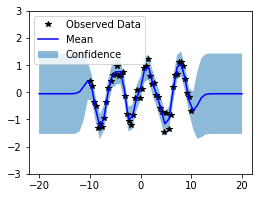

In [33]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

## Adaptation to 2D problem

In [122]:
import math

In [139]:
nsamples = 100
x= np.random.rand(nsamples, 2)
y = np.sin(x[:,0] + 2*x[:,1]) + np.random.randn(nsamples) * np.sqrt(0.04)

train_x = torch.from_numpy(x).float()
train_y = torch.from_numpy(y).float()

class ExactGPModel(gpytorch.models.ExactGP):

    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)  
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
                            gpytorch.kernels.RBFKernel(ard_num_dims=2,
                                                      has_lengthscale=True))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# just showing how initial values to hyper parameters can be given
hypers = {
    'likelihood.noise_covar.noise': torch.tensor(.01),
    'covar_module.base_kernel.lengthscale': torch.tensor([1.,1.]),
    'covar_module.outputscale': torch.tensor(1.),
     }

model.initialize(**hypers);  

print(model.covar_module.base_kernel.lengthscale[0])

tensor([1., 1.], grad_fn=<SelectBackward>)


In [142]:
model.train() 
likelihood.train();

optimizer = torch.optim.Adam([
                {'params': model.parameters()},  
                              ], lr=0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


training_iter = 500 # set as many stels as we want to take 

for i in range(training_iter):
    
        # Zero gradients from previous iteration
    optimizer.zero_grad()

    # Output from model
    output = model(train_x)

    # Calc loss and backprop gradients
    # loss is defined is -log(p(Y(x)))

    # the way the PyTorch optimizer works is that it looks for a variable called loss,
    # which also has a gradient (calc by calling backward), and tries to reduce it.
    loss = -mll(output, train_y)

    loss.backward()
    
    if np.mod(i,10)==0:
        print('Iter %d/%d - Loss: %.3f   lengthscale1: %.3f lengthscale2: %.3f  noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale[0][0].item(),
            model.covar_module.base_kernel.lengthscale[0][1].item(),
            model.likelihood.noise.item()
              ))

    optimizer.step()

Iter 1/500 - Loss: -0.027   lengthscale1: 0.783 lengthscale2: 0.436  noise: 0.044
Iter 11/500 - Loss: -0.026   lengthscale1: 0.823 lengthscale2: 0.455  noise: 0.046
Iter 21/500 - Loss: -0.027   lengthscale1: 0.798 lengthscale2: 0.446  noise: 0.045
Iter 31/500 - Loss: -0.027   lengthscale1: 0.785 lengthscale2: 0.435  noise: 0.044
Iter 41/500 - Loss: -0.027   lengthscale1: 0.777 lengthscale2: 0.433  noise: 0.044
Iter 51/500 - Loss: -0.027   lengthscale1: 0.778 lengthscale2: 0.433  noise: 0.044
Iter 61/500 - Loss: -0.027   lengthscale1: 0.781 lengthscale2: 0.434  noise: 0.044
Iter 71/500 - Loss: -0.027   lengthscale1: 0.782 lengthscale2: 0.435  noise: 0.044
Iter 81/500 - Loss: -0.027   lengthscale1: 0.783 lengthscale2: 0.436  noise: 0.044
Iter 91/500 - Loss: -0.027   lengthscale1: 0.783 lengthscale2: 0.436  noise: 0.044
Iter 101/500 - Loss: -0.027   lengthscale1: 0.783 lengthscale2: 0.436  noise: 0.044
Iter 111/500 - Loss: -0.027   lengthscale1: 0.783 lengthscale2: 0.436  noise: 0.044
Ite